In [1]:
%load_ext autoreload
%autoreload 2
from alt_model_checkpoint import AltModelCheckpoint
from keras.utils import multi_gpu_model
from keras.optimizers import Adam
import os
import cv2 as cv
import numpy as np
import sys
sys.path.insert(0, "../../")
from scripts.saliency.predict_saliency import SaliencyPredictor
from matplotlib.pyplot import imshow

Using TensorFlow backend.


In [2]:
predictor = SaliencyPredictor("../../model_checkpoints/saliency.34-val_loss-0.9297.hdf5")

In [3]:
predictor.load_model()

In [6]:
pred = predictor.predict_path("C:\\Workspace\\SalienceModel\\Salient-Object-Detection\\test\\t1.jpg")

yea
(1, 448, 320, 1)
(1, 448, 320, 1)


In [19]:
model = predictor.model

In [7]:
img = cv.imread("C:\\Workspace\\ThesisImageMatting\\images\\person.jpg")

In [25]:
img_resized = cv.resize(img, (320, 448)).reshape(448, 320, 3)

In [13]:
original_shape = img.shape
img_resized = cv.resize(img, (320, 480)).reshape(1, 480, 480, 3)
prediction = self.model.predict(img_resized)
z_fuse = prediction[6]
z2 = prediction[1]
z3 = prediction[2]
z4 = prediction[3]
print(z_fuse.shape)
avg = (z_fuse + z2 + z3 + z4) / 4
print(avg.shape)
avg = z_fuse.reshape(448, 320, 1)
image_back_to_normal_size = cv.resize(avg, (original_shape[1], original_shape[0]))
return image_back_to_normal_size

NameError: name 'self' is not defined

In [147]:
def check_point_in_square(point, square):
    point_x, point_y = point
    x, y, width, height = square
    
    if point_x >= x and point_x <= x + width and point_y >= y and point_y <= y + height:
        return True
    else:
        return False

In [85]:
def check_point_in_squares(point, squares):
    for square in squares:
        if check_point_in_square(point, square) is True:
            return True
    return False

In [148]:
def make_new_square(center, img_width, img_height):
    center_x, center_y = center
    top_x = center_x - 160
    top_y = center_y - 160
    print(top_x, top_y, img_width, img_height)
    if top_x < 0:
        top_x = 0
    if top_y < 0:
        top_y = 0
    
    if top_x + 320 > img_width:
        how_much_greater = top_x + 320 - img_width 
        top_x -= how_much_greater
        
    if top_y + 320 > img_height:
        
        how_much_greater =  top_y + 320 - img_height
        print(how_much_greater)
        top_y -= how_much_greater
        
    return top_x, top_y, 320, 320
    

In [146]:
def intersection(square, other_square):
        s_x1, s_y1, s_width, s_height = square
        s_x2 = s_x1 + s_width
        s_y2 = s_y1 + s_height
        o_x1, o_y1, o_width, o_height = other_square
        o_x2 = o_x1 + o_width
        o_y2 = o_y2 + o_height
        
        x1 = max(min(s_x1, s_x2), min(o_x1, o_x2))
        y1 = max(min(s_y1, s_y2), min(o_y1, o_y2))
        x2 = min(max(s_x1, s_x2), max(o_x1, o_x2))
        y2 = min(max(s_y1, s_y2), max(o_y1, o_y2))
        if x1<x2 and y1<y2:
            return (x1, y1, x2, y2)
        else:
            return None

In [133]:
def draw_all_squares_on_img(img, squares):
    img = img.copy()
    for square in squares:
        center, squ = square
        top_x, top_y, width, height = squ
        bottom_x = top_x + width
        bottom_y = top_y + height
        print(top_x, top_y, bottom_x, bottom_y)
        img = cv.rectangle(img, (top_x, top_y), (bottom_x, bottom_y), (255, 0, 0), 3)
        img = cv.circle(img, center, 10, (0, 255, 0), -1)
    return img

In [149]:
def patches_of_culture(img, trimap):
    img_width, img_height = img.shape[1], img.shape[0]
    y_indices, x_indices = np.where(trimap == 128)
    unknown_pixels  = list(zip(x_indices, y_indices))
    covered_pixels = set()
    squares = []
    for pixel in unknown_pixels:
        if check_point_in_squares(pixel, squares) is True:
            continue
        square = make_new_square(pixel, img_width, img_height)
        squares.append(square)
    return squares
    

In [136]:
img_width, img_height = trimap.shape[1], trimap.shape[0]

In [137]:
img_width

1280

In [150]:
squares = patches_of_culture(trimap, trimap[:, :, 0])

442 -88 1280 720
603 -35 1280 720
352 161 1280 720
568 161 1280 720
729 305 1280 720
251 322 1280 720
799 466 1280 720
66
144 483 1280 720
83


In [181]:
def get_crops_by_squares(img, trimap, squares):
    crops = np.empty((len(squares), 320, 320, 4))
    for index, square in enumerate(squares):
        crops[index, :, :, 0:3] = img[square[1]:square[1]+320, square[0]:square[0]+320, :].reshape(1, 320, 320, 3) / 255
        crops[index, :, :, 3:4] = trimap[square[1]:square[1]+320, square[0]:square[0]+320, :].reshape(1, 320, 320, 1) / 255
    return crops

In [190]:
def combine_predictions(predictions, squares, original_shape):
    out = np.zeros((original_shape[0], original_shape[1], 1))
    mask = np.zeros((original_shape[0], original_shape[1], 1))
    for index, square in enumerate(squares):
        out[square[1]:square[1]+320, square[0]:square[0]+320, :] += predictions[index]
        mask[square[1]:square[1]+320, square[0]:square[0]+320, :] += (predictions[index] > 0)
    mask[mask == 0] = 1
    return out / mask

In [182]:
crops = get_crops_by_squares(img, trimap[:, :, 0:1], squares)

In [184]:
crops[0].shape

(320, 320, 4)

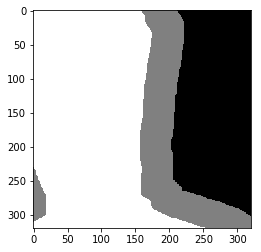

In [189]:
imshow(crops[3][:, :, 3], cmap="gray")

In [160]:
img[600:700, :, :].shape

(100, 1280, 3)

In [151]:
squares

[(442, 0, 320, 320),
 (603, 0, 320, 320),
 (352, 161, 320, 320),
 (568, 161, 320, 320),
 (729, 305, 320, 320),
 (251, 322, 320, 320),
 (799, 400, 320, 320),
 (144, 400, 320, 320)]

In [144]:
tr = draw_all_squares_on_img(trimap, squares)

442 0 762 320
603 0 923 320
352 161 672 481
568 161 888 481
729 305 1049 625
251 322 571 642
799 400 1119 720
144 400 464 720


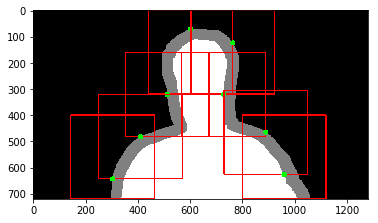

In [145]:
imshow(tr)

In [117]:
trimap.shape

(720, 1280, 3)

In [105]:
x_indices, y_indices = np.where(trimap[:, :, 0] == 128)

In [108]:
max(y_indices)

1058

In [24]:
img_resized.shape

(320, 448, 3)

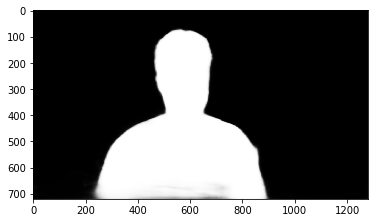

In [7]:
imshow(pred, cmap="gray")

In [210]:
img = cv.imread("../../images/t7.jpg")
trimap = cv.imread("../../output/trimap.png")

bg = cv.imread("../../images/hawaii2.jpg")
alpha = cv.imread("../../output/alpha.png") /255
alpha2 = cv.imread("../../output/alpha_t8.png")/255

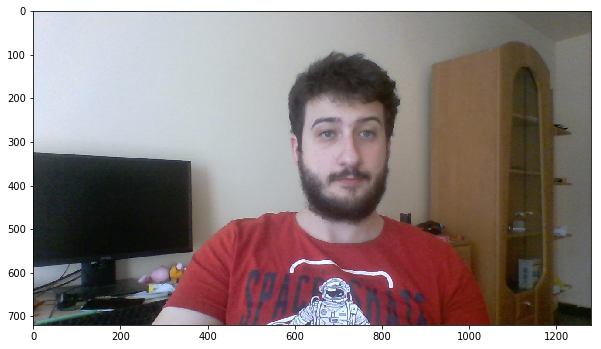

In [214]:
figure(figsize=(10, 10))
imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))

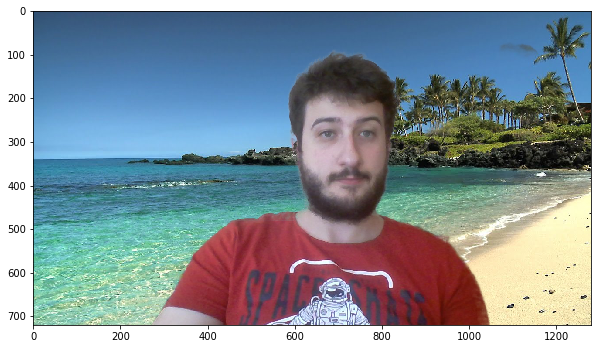

In [216]:
figure(figsize=(10, 10))
bg = cv.GaussianBlur(img.astype(np.uint8),(155,155),0)
imshow(cv.cvtColor(((img * alpha) + (1-alpha) * bg_crop).astype(np.uint8),cv.COLOR_BGR2RGB))

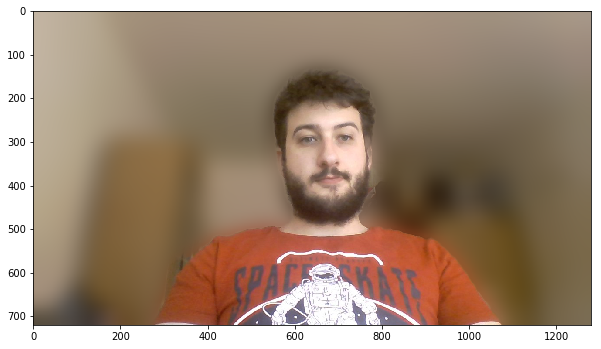

In [209]:
figure(figsize=(10, 10))
bg = cv.GaussianBlur(img.astype(np.uint8),(155,155),0)
imshow(cv.cvtColor(((img * alpha) + (1-alpha) * bg).astype(np.uint8),cv.COLOR_BGR2RGB))

In [44]:
alpha_shape = alpha.shape
bg_crop = bg[0:alpha.shape[0], 0:alpha.shape[1]]

In [42]:
bg_crop.shape

(641, 960, 3)

In [18]:
from matplotlib.pyplot import imshow, figure


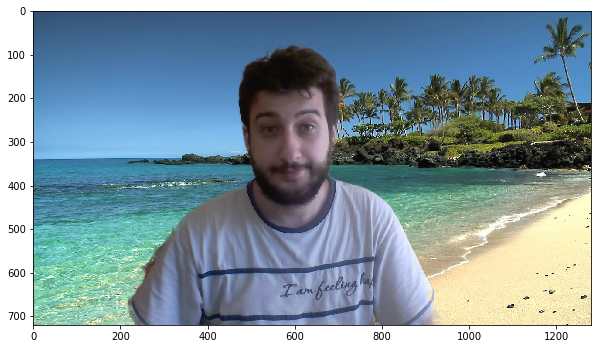

In [65]:
figure(figsize=(10, 10))
bg = cv.GaussianBlur(img * (1-alpha).astype(np.uint8),(55,55),0)
imshow(cv.cvtColor(((img * alpha) + (1-alpha) * bg_crop).astype(np.uint8),cv.COLOR_BGR2RGB))

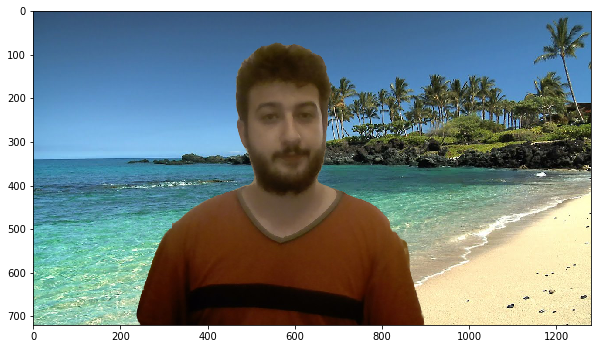

In [46]:
figure(figsize=(10, 10))
bg = cv.GaussianBlur(img * (1-alpha).astype(np.uint8),(55,55),0)
imshow(cv.cvtColor(((img * alpha) + (1-alpha) * bg_crop).astype(np.uint8),cv.COLOR_BGR2RGB))

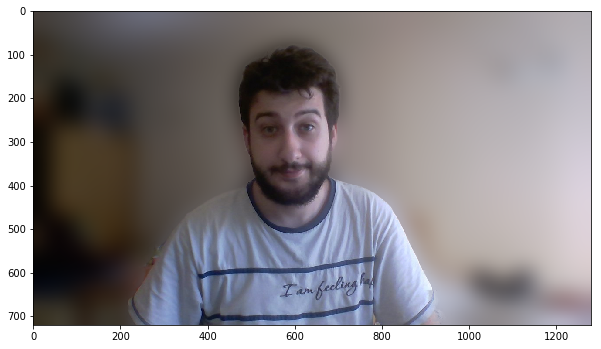

In [66]:
figure(figsize=(10, 10))
bg = cv.GaussianBlur(img.astype(np.uint8),(155,155),0)
imshow(cv.cvtColor(((img * alpha) + (1-alpha) *bg).astype(np.uint8),cv.COLOR_BGR2RGB))

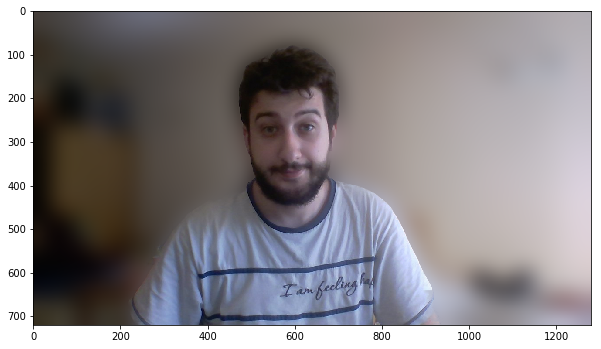

In [59]:
figure(figsize=(10, 10))
bg = cv.GaussianBlur(img.astype(np.uint8),(155,155),0)
imshow(cv.cvtColor(((img * alpha) + (1-alpha) *bg).astype(np.uint8),cv.COLOR_BGR2RGB))

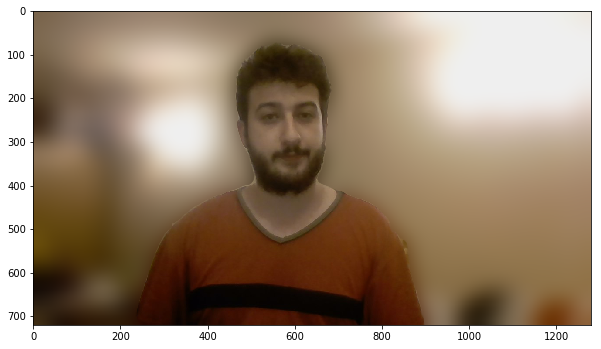

In [51]:
figure(figsize=(10, 10))
bg = cv.GaussianBlur(img.astype(np.uint8),(155,155),0)
imshow(cv.cvtColor(((img * alpha) + (1-alpha) *bg).astype(np.uint8),cv.COLOR_BGR2RGB))

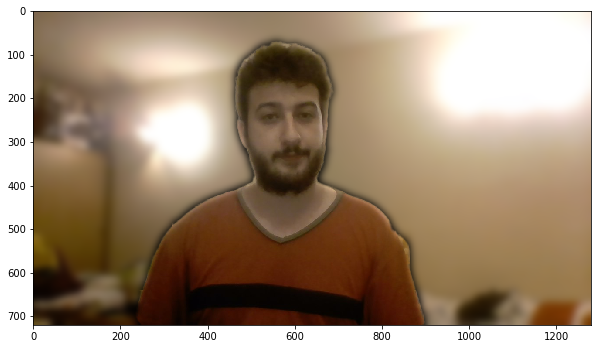

In [35]:
figure(figsize=(10, 10))
bg = cv.GaussianBlur(img * (1-alpha).astype(np.uint8),(55,55),0)
imshow(cv.cvtColor(((img * alpha2) + bg).astype(np.uint8),cv.COLOR_BGR2RGB))